In [33]:
import pymatgen as pmg
from pymatgen.io.vasp.outputs import Vasprun
from pymatgen.electronic_structure.plotter import DosPlotter
from pymatgen.core.periodic_table import Element
from pymatgen.electronic_structure.core import Spin, Orbital
from pymatgen.electronic_structure.dos import Dos, DOS
import functools
import numpy as np

from os.path import expanduser
home = expanduser('~')

from matplotlib.pyplot import figure

import matplotlib.pyplot as pyplot
from scipy.integrate import trapz, simps, cumtrapz

import warnings
warnings.filterwarnings("ignore")


def integrate(axis, line_idx, start, end, label=None, down=False, color=None):
    """Integrates the given DoS data"""
    line = axis.get_lines()[line_idx]
    
    x = line.get_xdata()[:3001]
    y = line.get_ydata()[:3001]
    
    if down:
        x = np.flip(x)
        y = np.flip(y)
    
    integral = cumtrapz(y, x=x, initial=0)
    
    pyplot.plot(x,y, label=label, color=color)
    pyplot.plot(x, integral, color=color, linestyle='--', label=label+' int')
    pyplot.axvline(x=x[0], linestyle='--', color='grey')
    pyplot.axvline(x=x[-1], linestyle='--', color='grey')
    pyplot.axhline(y=0, color='k')
    pyplot.grid(1)
    pyplot.legend()


def norm_dos(dos, factor):
    dos_dict = dos.as_dict()
    for key in dos_dict['densities'].keys():
        dos_dict['densities'][key] = np.array(dos_dict['densities'][key])/factor
    return Dos.from_dict(dos_dict)


def plot_dos(prefix, loc, iters_1, dos_type, by_element=[], by_site=[], projection_sites=[], 
             orbital_ls=[4,5,6,7,8], orbital_names=['dxy', 'dyz', 'dz2', 'dxz', 'dx2'], 
             width=8, height=5, label_font=20, norm_factor=1, plot_total=False, 
             xlims=[None, None], ylims=[None, None]):
    
    axes = []

    for i, iter_1 in enumerate(iters_1):
    #     for j, iter_2 in enumerate(iters_2):

            label = f'{prefix}{iter_1}'

            # Extract dos from vasprun
            vr = Vasprun(f'{loc}-{label}.xml')
            cdos = vr.complete_dos
            pdoss = cdos.pdos
            tdos = norm_dos(vr.tdos, norm_factor)

            dplt = DosPlotter()

            # Add total dos
            if plot_total:
                dplt.add_dos("Total", tdos)

            # Add orbital-projected DOS
            if dos_type == 'orbital':
                for site_idx in projection_sites[i]:
                    for orbital, name in zip(orbital_ls, orbital_names):
                        site = cdos.structure[site_idx]
                        elem = site.species.elements[0]
                        efermi = cdos.efermi
                        energies = cdos.energies
                        orb_dos = pdoss[site][Orbital(orbital)]
                        dplt.add_dos(f'{elem}-{name}',
                                     Dos(efermi, energies, orb_dos))
#                         for spin, spin_label in [(Spin.up, 'up'), (Spin.down, 'down')]:
#                             spin_doss = (pdoss[site][Orbital(orb_num)][spin] for orb_num in orbitals)

#                             dplt.add_dos(f'{elem}-{spin_label}', 
#                                          Dos(efermi, energies, sum(s))

            # Add spin-sep site doss
            if dos_type == 'site-spin':
                for site_idx, orbitals in zip(by_site, [orbital_ls]*len(by_site)):
                    site = cdos.structure[site_idx]
                    elem = site.species.elements[0]
                    efermi = cdos.efermi
                    energies = cdos.energies
                    for spin, spin_label in [(Spin.up, 'up'), (Spin.down, 'down')]:
                        spin_doss = (pdoss[site][Orbital(orb_num)][spin] for orb_num in orbitals)

                        dplt.add_dos(f'{elem}-{spin_label}', 
                                     Dos(efermi, energies, {spin: sum(spin_doss)}))
            
            # Add site doss
            if dos_type == 'site':
                for site_idx in by_site:
                    site = cdos.structure[site_idx]
                    elem = cdos.structure[2].species.elements[0]
                    dos = cdos.get_site_dos(site)
                    dplt.add_dos(f'{elem}{site_idx}', dos)

            # Add element dos
            elem_doss = cdos.get_element_dos()
            for element in by_element:
                dplt.add_dos(element, norm_dos(elem_doss[Element(element)], 4))

            # Customize plot
            dos_plot = dplt.get_plot()
            dos_plot.xlim(xlims)
            dos_plot.ylim(ylims)
            dos_plot.axvline(x=0, color='k', linestyle='-')
            dos_plot.grid(1)

    #       # Make total line grey and filled in
    #         totLine = dos_plot.gca().get_lines()[3]
    #         totLine.set_color('silver')

            dos_plot.legend(loc='upper right', ncol=6, fontsize=label_font-3) #keep line thick in legend

    #         totLine.set_linewidth(1)   
    #         totX = totLine.get_xdata()
    #         totY = totLine.get_ydata()
    #         dos_plot.fill_between(totX, totY, where=totY>=-totY, interpolate=True, color='silver')
    #         dos_plot.fill_between(totX, totY, where=totY<=-totY, interpolate=True, color='silver')

            # Add a label to bottom right
            t = dos_plot.text(0.0, 0.0, label, horizontalalignment='left', 
                          verticalalignment='bottom', transform=dos_plot.gca().transAxes, 
                          fontsize=label_font, color='grey')
            t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='grey'))
            
            # Change font size
            dos_plot.gca().xaxis.label.set_fontsize(label_font)
            dos_plot.gca().yaxis.label.set_fontsize(label_font)
            pyplot.xticks(fontsize=label_font-5)
            pyplot.yticks(fontsize=label_font-5)

            # Add axes to persistent list
            axes.append(dos_plot.gca())

            # Resize/reshape
            fig = dos_plot.gcf()
            fig.set_size_inches(width,height)

            # Show and save
            dos_plot.tight_layout()
            dos_plot.show()
            fig.savefig(f"elec_dos-proj-{label}.png", img_format="png", dpi=300)
    #         fig.savefig(f"elec_dos-proj-vec-{label}.pdf", img_format="pdf")

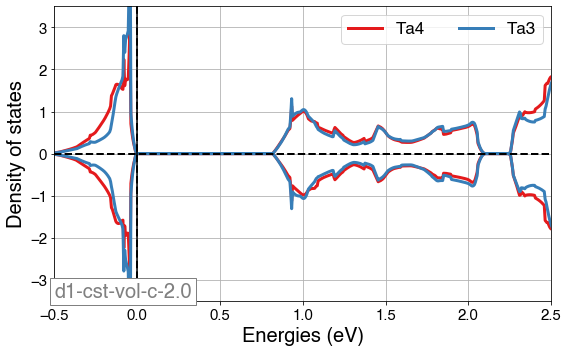

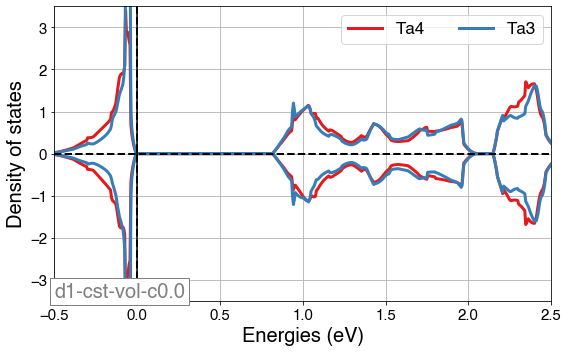

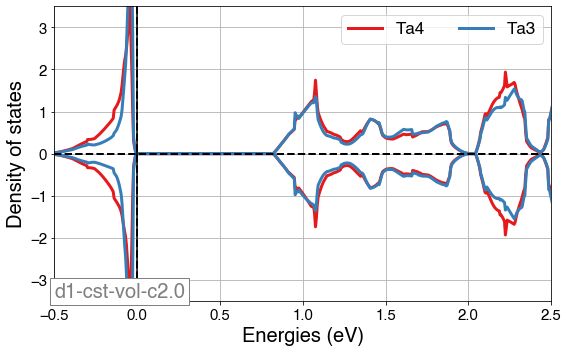

In [35]:
loc = home + '/Projects/trirutiles-study/carrier_doping/strain-is2-estruc/vasprun-dos'
iters = [np.round(item, 1) for item in np.linspace(-2,2,3)]
            
plot_dos("d1-cst-vol-c", loc, iters, 'site', by_site=[3,4], norm_factor=2, 
         xlims=[-0.5, 2.5], ylims=[-3.5,3.5])

### U = 0 ###


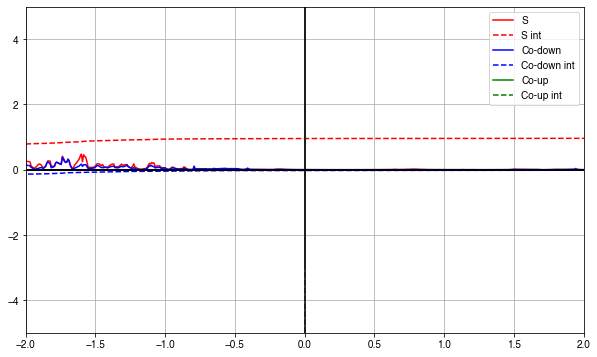

In [19]:
# spin-polarized (dos is halved) and 2 Ta per f.u., 2 f.u. per u.c. 
line_idx = 1
fig = pyplot.figure(figsize=(10,6))

iters = [(0, 'S', False, 'red'), (1, 'Co-down', True, 'blue'), (2, 'Co-up', False, 'green'), (3, 'Total', False, 'grey')]

print('### U = 0 ###')
for line_idx, label, down, color in iters[:-1]:
    integrate(axes[0], line_idx, 1, 2, label=label, down=down, color=color)

pyplot.ylim(-5,5)
pyplot.xlim(-2,2)
pyplot.axvline(x=0, color='k')
pyplot.show()